In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau

import h5py
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam, SGD, Nadam

In [4]:
path = '/output/dogscats/'
batch_size = 32

Define get_feat() function that returns output features  of base model<br>
code from https://github.com/ypwhs/dogs_vs_cats

In [5]:
def get_feats(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(path+'train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    valid_generator = gen.flow_from_directory(path+'valid', image_size, shuffle=False, 
                                              batch_size=batch_size)
    #test_generator = gen.flow_from_directory(path+'test', image_size, shuffle=False, 
    #                                         batch_size=batch_size, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    valid = model.predict_generator(valid_generator, valid_generator.nb_sample)
    #test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("feats_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        #h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        h.create_dataset("val_label", data=valid_generator.classes)

In [31]:
def plot_history(hists, attribute='val_loss', axis=(-10,310,0.965,0.983), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn._ accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(10, 6))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['SGD(SELU)', 'Adam(SELU)', 'SGD(ReLU)', 'Adam(ReLU)', 'SGD(PReLU)', 'Adam(PReLU)'], loc=loc)  

    plt.show()

In [7]:
from keras import backend as K

Implementation of SELU(scaled exponential linear unit) <br>
From: https://github.com/bioinf-jku/SNNs/blob/master/SelfNormalizingNetworks_CNN_MNIST.ipynb

There's a finction called dropout_selu() in the source notebook, which implement alpha dropout that keeps output mean/var. invariant. <br>
But here we use only selu().

In [8]:
def selu(x):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale*K.tensorflow_backend.tf.where(x>0.0, x, alpha*K.tensorflow_backend.tf.exp(x)-alpha)

Precompute ResNet50 output features

In [9]:
%time get_feats(ResNet50, (224, 224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
CPU times: user 5min 54s, sys: 25.9 s, total: 6min 20s
Wall time: 10min 41s


Load precomputed features

In [10]:
X_train = []
X_valid = []
X_test = []

for filename in ["feats_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        #X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
#X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

# Experiment 1: FC layers w/ callback=ReduceLROnPlateau()#

Result: all activations result val_acc at the same level

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
eps = 150
w_l2 = 5e-4

**Model 1: SGD(SELU)**

In [44]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgd_selu = Model(input_tensor, x)
model_sgd_selu.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgd_selu = model_sgd_selu.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


**Model 2: Adam(SELU)**

In [87]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adam_selu = Model(input_tensor, x)
model_adam_selu.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
hist_adam_selu = model_adam_selu.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


**Model 3: SGD(ReLU)**

In [52]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgd_relu = Model(input_tensor, x)
model_sgd_relu.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgd_relu = model_sgd_relu.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


**Model 4: Adam(ReLU)**

In [53]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adam_relu = Model(input_tensor, x)
model_adam_relu.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
hist_adam_relu = model_adam_relu.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


**Model 5: SGD(PReLU)**

In [98]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgd_prelu = Model(input_tensor, x)
model_sgd_prelu.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgd_prelu = model_sgd_prelu.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


**Model 6: Adam(PReLU)**

In [56]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adam_prelu = Model(input_tensor, x)
model_adam_prelu.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
hist_adam_prelu = model_adam_prelu.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=eps, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

print ('Done.')

Done.


## Plot Figures##

In [99]:
hists = [hist_sgd_selu, hist_adam_selu, hist_sgd_relu, hist_adam_relu, hist_sgd_prelu, hist_adam_prelu]

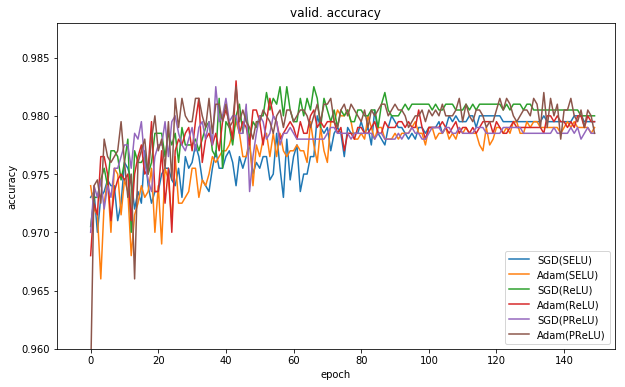

In [100]:
plot_history(hists, attribute='val_acc', axis=(-10,155,0.96,0.988), loc='lower right')

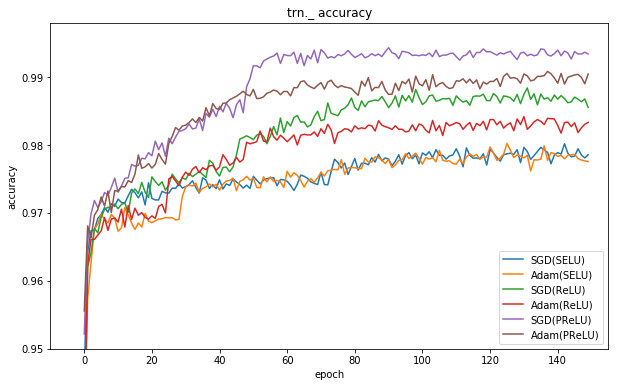

In [108]:
plot_history(hists, attribute='acc', axis=(-10,155,0.95,0.998), loc='lower right')

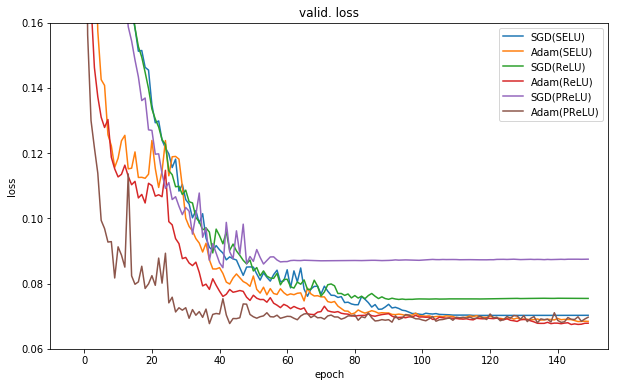

In [107]:
plot_history(hists, attribute='val_loss', axis=(-10,155,0.060,0.16), loc='upper right')

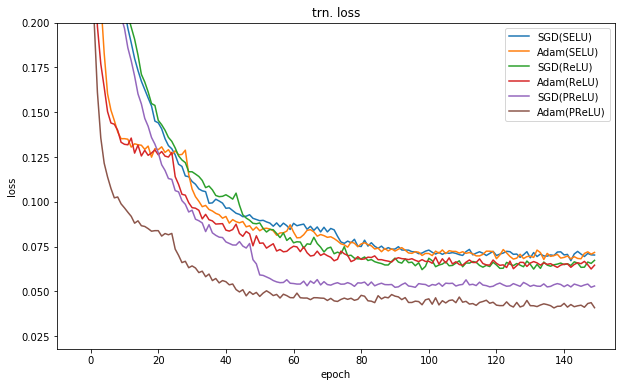

In [106]:
plot_history(hists, attribute='loss', axis=(-10,155,0.018,0.2), loc='upper right')

# Experiment 2:  FC layers w/ fixed learning rate#

Result: no huge different between activations (Adam performs better than SGD because its intrinsic adaptivity.)

In [111]:
learningrate = 1e-4

In [131]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_selu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)


In [132]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_selu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)

In [133]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_relu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)

In [134]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_relu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)

In [135]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_prelu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)

In [136]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_prelu2 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=150, validation_data=(X_valid,y_valid), verbose=0)

In [137]:
hists = [hist_sgd_selu2, hist_adam_selu2, hist_sgd_relu2, hist_adam_relu2, hist_sgd_prelu2, hist_adam_prelu2]

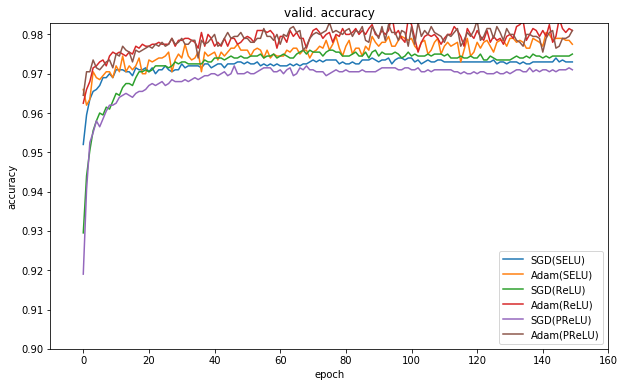

In [138]:
plot_history(hists, attribute='val_acc', axis=(-10,160,0.90,0.983), loc='lower right')

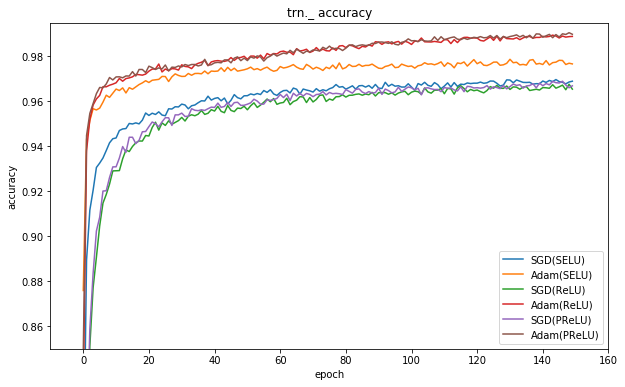

In [139]:
plot_history(hists, attribute='acc', axis=(-10,160,0.85,0.995), loc='lower right')

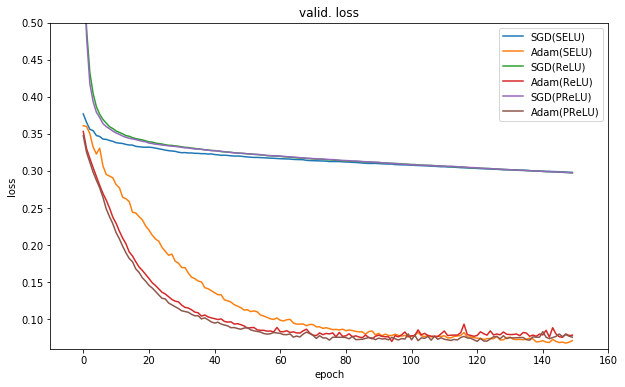

In [141]:
plot_history(hists, attribute='val_loss', axis=(-10,160,0.060,0.5), loc='upper right')

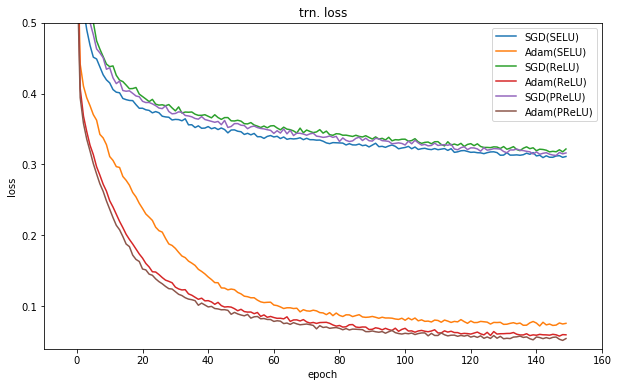

In [140]:
plot_history(hists, attribute='loss', axis=(-10,160,0.04,0.5), loc='upper right')

# Experiment 3:  FC layers w/ fixed lr and w/o dropout#

Result: The Adam models quickly overfit but have similar result to exp. 2.

In [159]:
input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation=selu)(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_selu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation=selu)(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_selu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation='relu')(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_relu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation='relu')(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_relu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2))(input_tensor)
x = PReLU()(x)
x = Dense(64, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_prelu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2))(input_tensor)
x = PReLU()(x)
x = Dense(64, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_prelu3 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

In [160]:
hists = [hist_sgd_selu3, hist_adam_selu3, hist_sgd_relu3, hist_adam_relu3, hist_sgd_prelu3, hist_adam_prelu3]

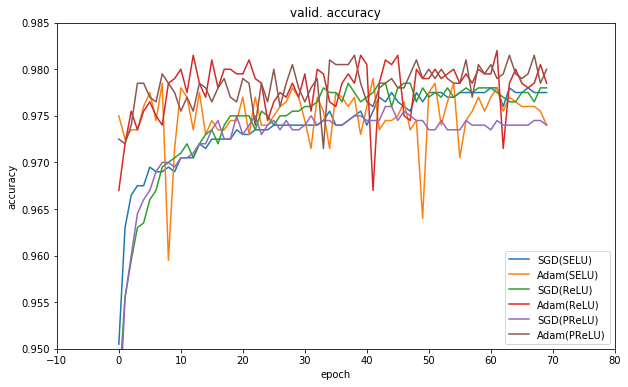

In [161]:
plot_history(hists, attribute='val_acc', axis=(-10,80,0.95,0.985), loc='lower right')

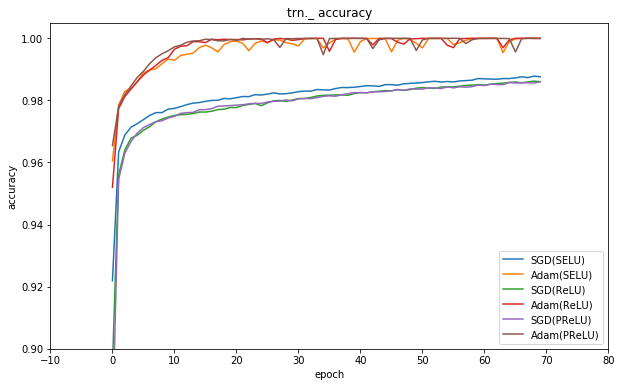

In [162]:
plot_history(hists, attribute='acc', axis=(-10,80,0.9,1.005), loc='lower right')

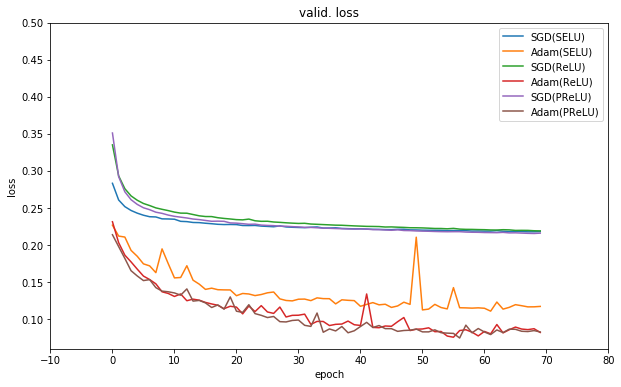

In [163]:
plot_history(hists, attribute='val_loss', axis=(-10,80,0.060,0.5), loc='upper right')

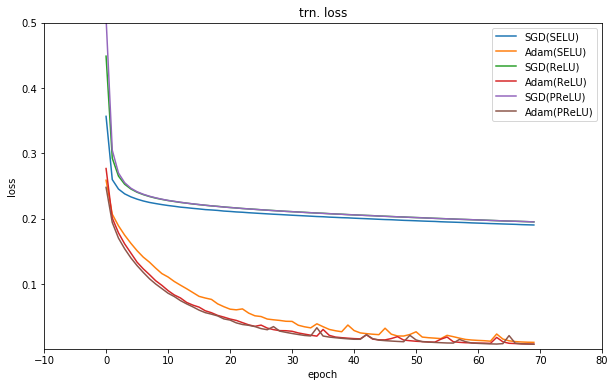

In [164]:
plot_history(hists, attribute='loss', axis=(-10,80,0.001,0.5), loc='upper right')

# Experiment 4:  FC layers w/ small lr and w/o dropout#

Result: SELU seems to have faster convergence

In [165]:
learningrate = 1e-6

In [166]:
input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation=selu)(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_selu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation=selu)(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_selu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation='relu')(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_relu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation='relu')(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_relu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2))(input_tensor)
x = PReLU()(x)
x = Dense(64, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_sgd_prelu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2))(input_tensor)
x = PReLU()(x)
x = Dense(64, W_regularizer = regularizers.l2(w_l2))(x)
x = PReLU()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = learningrate
hist_adam_prelu4 = model.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=70, validation_data=(X_valid,y_valid), verbose=0)

In [167]:
hists = [hist_sgd_selu4, hist_adam_selu4, hist_sgd_relu4, hist_adam_relu4, hist_sgd_prelu4, hist_adam_prelu4]

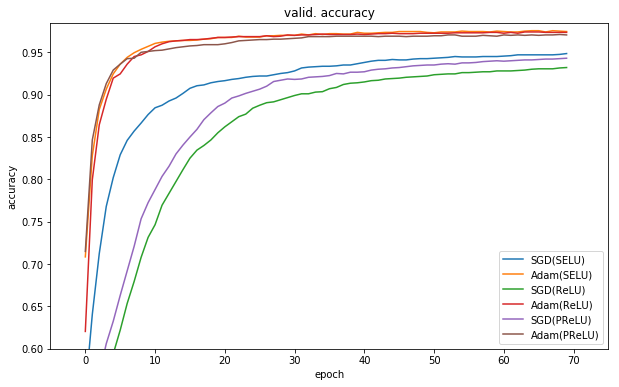

In [175]:
plot_history(hists, attribute='val_acc', axis=(-5,75,0.6,0.985), loc='lower right')

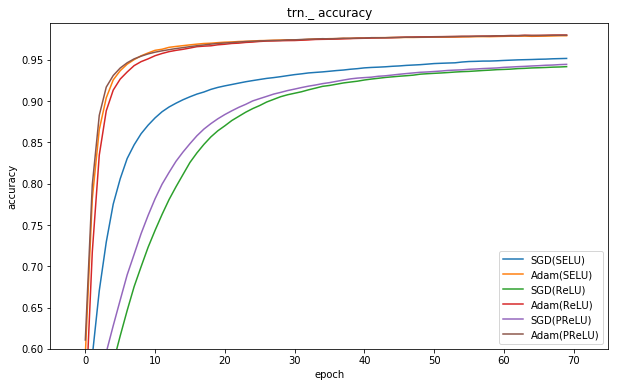

In [177]:
plot_history(hists, attribute='acc', axis=(-5,75,0.6,0.995), loc='lower right')

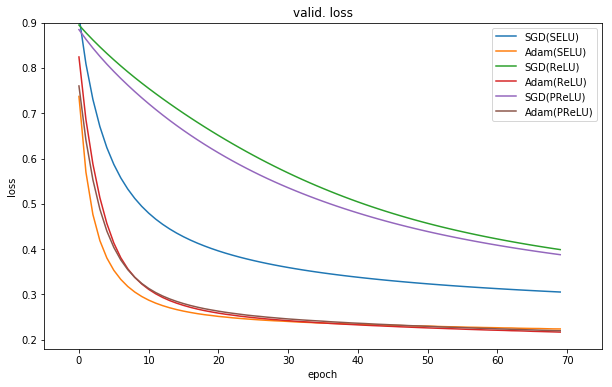

In [181]:
plot_history(hists, attribute='val_loss', axis=(-5,75,0.18,0.9), loc='upper right')

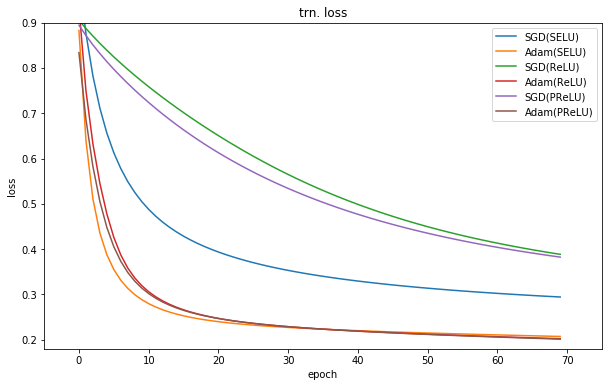

In [182]:
plot_history(hists, attribute='loss', axis=(-5,75,0.18,0.9), loc='upper right')

In [185]:
!pip install pydot

  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /root/.cache/pip/wheels/47/8c/c2/4ac7bd0219b4ce5e08d03dc3467014c7a94b2efecfc29df2b2
Successfully built pydot


In [187]:
!pip install graphviz

In [188]:
from keras.utils.visualize_util import plot  

input_tensor = Input(X_train.shape[1:])
x = Dense(128, W_regularizer = regularizers.l2(w_l2), activation=selu)(input_tensor)
x = Dense(64, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
model.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
plot(model, to_file='model3.png')  

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
plot(model, to_file='model2.png')  

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.5)(input_tensor)
x = Dense(256, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(32, W_regularizer = regularizers.l2(w_l2), activation=selu)(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)
plot(model, to_file='model1.png')  

AttributeError: module 'pydot' has no attribute 'find_graphviz'

To fix this bug, please see:<br>
http://www.codesofinterest.com/2017/02/visualizing-model-structures-in-keras.html